# Attribution Measurement Workflows

This notebook contains three digital advertising campaign attribution measurement workflows. The format of the sample input data is informed by the schemas defined in the [**Attribution Data Matching Protocol (ADMaP) specification**](https://iabtechlab.com/admap/) and **Universal CAPI v1**.

## Example ADMaP-Compatible Data

A few common dependencies are leveraged to generate example data.

In [1]:
import random
from tqdm.notebook import tqdm
import faker

A common space of keys (emails) is generated below and used for generating simulated data within different data sets.

In [2]:
random.seed(123)
faker.Faker.seed(123)
fake = faker.Faker()
emails = [fake.email() for _ in tqdm(range(10000))]

  0%|          | 0/10000 [00:00<?, ?it/s]

The function below is used to display data as a table.

In [3]:
import pandas as pd

def table(data, columns):
    df = pd.DataFrame(data, columns=columns)
    return df

### Publisher Engagement Events

In [4]:
es = random.sample(emails, 10000)
campaigns = ['Red', 'Orange', 'Yellow', "Green", "Blue", "Purple"]
regions = ['NA', 'LATAM', 'EMEA', 'APAC', 'ROW']

events = [
    [
        random.randint(1, 1),        # Space ID
        es[i],                       # user_data.email_address
        'click',                     # event_type
        random.choice(campaigns),    # event_properties.promotion_name
        random.choice(regions),      # user_data.address.region
        random.choice([False, True]) # user_data.opt_out
    ]
    for i in tqdm(range(5000))
]

table(
    events,
    [
        "Space ID",
        "user_data.email_address",
        "event_type",
        "event_properties.promotion_name",
        "user_data.address.region",
        "user_data.opt_out"
    ]
)

  0%|          | 0/5000 [00:00<?, ?it/s]

,Space ID,user_data.email_address,event_type,event_properties.promotion_name,user_data.address.region,user_data.opt_out
0,1,ugates@example.com,click,Purple,LATAM,True
1,1,varnold@example.net,click,Purple,ROW,False
2,1,moorewayne@example.com,click,Yellow,LATAM,True
3,1,jamesrogers@example.net,click,Blue,ROW,False
4,1,cranekenneth@example.org,click,Blue,ROW,True
...,...,...,...,...,...,...
4995,1,cgray@example.org,click,Purple,LATAM,True
4996,1,richard35@example.net,click,Orange,ROW,False
4997,1,ryanheath@example.org,click,Green,ROW,True
4998,1,pottstroy@example.net,click,Yellow,ROW,True


### Advertiser Conversions

In [5]:
es = random.sample(emails, 1000)
names = ['Purchase', 'Subscription']

conversions = [
    [
        random.randint(1, 1), # Space ID
        es[i],                # user_data.email_address
        random.choice(names)  # event_type
    ]
    for i in range(len(es))
]

table(conversions, ["Space ID", "user_data.email_address", "event_type"])

,Space ID,user_data.email_address,event_type
0,1,johnsonkelli@example.org,Subscription
1,1,margaret51@example.com,Subscription
2,1,valerie23@example.org,Purchase
3,1,yguzman@example.org,Purchase
4,1,wellsjessica@example.com,Subscription
...,...,...,...
995,1,williamsstephen@example.net,Subscription
996,1,jerryerickson@example.net,Subscription
997,1,terrellbrian@example.net,Subscription
998,1,rgriffith@example.com,Subscription


## Privacy-Preserving Aggregation of Conversions with $k$-anonymity

The workflow below (in its plaintext reference version) joins the publisher engagement events with the advertiser conversions and aggregates the number of conversions for each distinct campaign in the overlap.

In [6]:
join = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        region_e,
        opt_e,
        type_c
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, opt_e) in events
    for (spaceid_c, key_c, type_c) in conversions
    if key_e == key_c
]

aggregate = [
    [
        campaign,
        sum([
            1
            for (_, _, campaign_, _, _, _,) in join
            if campaign == campaign_
        ])
    ]
    for campaign in {campaign_ for [_, _, campaign_, _, _, _] in join} # Unique campaigns.
]

table(aggregate, ["event_properties.promotion_name", "count(Purchase|Subscription)"])

,event_properties.promotion_name,count(Purchase|Subscription)
0,Orange,77
1,Purple,86
2,Red,91
3,Yellow,87
4,Green,91
5,Blue,92


## Privacy-Preserving Aggregation of Conversions with Differential Privacy

The workflow below (in its plaintext reference version) joins the publisher engagement events with the advertiser conversions and aggregates the number of conversions for each distinct campaign in the overlap.

In [18]:
join = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        region_e,
        opt_e,
        type_c
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, opt_e) in events
    for (spaceid_c, key_c, type_c) in conversions
    if key_e == key_c
]

aggregate = [
    [
        campaign,
        sum([
            1
            for (_, _, campaign_, _, _, _,) in join
            if campaign == campaign_
        ])
    ]
    for campaign in {campaign_ for [_, _, campaign_, _, _, _] in join} # Unique campaigns.
]

columns = ["event_properties.promotion_name", "count(Purchase|Subscription)"]
table(aggregate, columns)

,event_properties.promotion_name,count(Purchase|Subscription)
0,Orange,77
1,Purple,86
2,Red,91
3,Yellow,87
4,Green,91
5,Blue,92


The workflow below computes a differentially private total for each campaign.

In [19]:
import polars as pl
import opendp.prelude as dp

dp.enable_features("contrib")

comparison = []
for campaign in tqdm(campaigns):
    filtered = [
        1
        for [spaceid_e, type_e, campaign_e, region_e, opt_e, type_c] in join
        if campaign_e == campaign
    ]
    df = pl.LazyFrame(filtered, orient="row")

    context = dp.Context.compositor(
        data=df,
        privacy_unit=dp.unit_of(contributions=5),
        privacy_loss=dp.loss_of(epsilon=1.0),
        split_evenly_over=10,
    )

    count_conversions = context.query().select(dp.len())

    comparison.append([
        campaign,
        len(filtered),
        count_conversions.release().collect()['len'][0]
    ])

df = table(comparison, ['campaign', 'non-DP', 'DP'])
df.loc['Total'] = df.sum(numeric_only=True)
df.loc['Total', 'campaign'] = ''
df

  0%|          | 0/6 [00:00<?, ?it/s]

,campaign,non-DP,DP
0,Red,91.0,17.0
1,Orange,77.0,74.0
2,Yellow,87.0,83.0
3,Green,91.0,25.0
4,Blue,92.0,121.0
5,Purple,86.0,125.0
Total,,524.0,445.0


The differentially private results are an example of *output privacy*: the final aggregate values are not exactly the true values and limit the amount of information that can be inferred about the inputs. However, *input privacy* is not achieved because the entity computing the differentially private results (such as a clean room) must use the raw data to calculate the differentially private results.

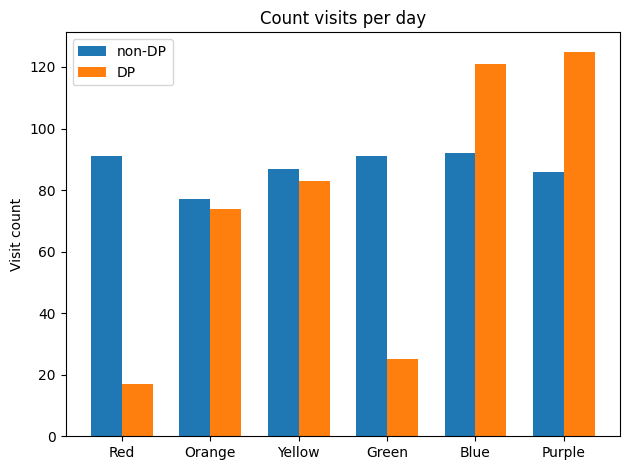

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(campaigns))

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df['non-DP'].tolist()[:-1], width, label='non-DP')
rects2 = ax.bar(x + width/2, df['DP'].tolist()[:-1], width, label='DP')
ax.set_ylabel('Visit count')
ax.set_title('Count visits per day')
ax.set_xticks(x)
ax.set_xticklabels(campaigns)
ax.legend()
fig.tight_layout()
plt.show()

## Privacy-Preserving Aggregation of Encrypted Conversion Data with Homomorphic Encryption

The workflow below (in its plaintext reference version) joins the publisher engagement events with the advertiser conversions and aggregates the number of conversions for each distinct campaign in the overlap.

In [10]:
join = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        type_c
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, opt_e) in events
    for (spaceid_c, key_c, type_c) in conversions
    if key_e == key_c
]

aggregate = [
    [
        campaign,
        sum([
            1
            for (_, _, campaign_, event) in join 
            if campaign == campaign_ and event == 'Purchase'
        ])
    ]
    for campaign in {campaign_ for [_, _, campaign_, _] in join} # Unique campaigns.
]

table(aggregate, ["event_properties.promotion_name", "count(Purchase)"])

,event_properties.promotion_name,count(Purchase)
0,Orange,45
1,Purple,35
2,Red,51
3,Yellow,46
4,Green,40
5,Blue,38


The conversions data below encrypts the event column. This is accomplished by splitting it into two columns (one for each possible event name), encoding the type of event by setting the appropriate column value to ``1`` (and the other column to ``0``), and then encrypting both columns

In [11]:
import pailliers

secret_key = pailliers.secret(128)
public_key = pailliers.public(secret_key)


conversions_enc = [
    [
        spaceid_c,
        key_c,
        pailliers.encrypt(public_key, 1 if name_c == 'Purchase' else 0),
        pailliers.encrypt(public_key, 1 if name_c == 'Subscription' else 0)
    ]
    for (spaceid_c, key_c, name_c) in conversions
]

table(conversions_enc, ["Space ID", "user_data.email_address", "event_type = Purchase", "event_type = Subcription"])

,Space ID,user_data.email_address,event_type = Purchase,event_type = Subcription
0,1,johnsonkelli@example.org,1700008562757190785780704792951353986942364891...,1375884657100397908395800349690293601740798818...
1,1,margaret51@example.com,2446506187660507621463541315328869282679126368...,4268582444432052472253296002423286324282653408...
2,1,valerie23@example.org,2990040861609949708495740302094714046488110897...,3497645444028963356716872912909418464935380828...
3,1,yguzman@example.org,7214358284834860323789738525861744015927990301...,5261582133689103678585886525383063948838247187...
4,1,wellsjessica@example.com,9468012815528111048964051473321318529840599206...,1544596251780464544037779569793684056001884911...
...,...,...,...,...
995,1,williamsstephen@example.net,3819485736630744083544651003336286852172236697...,3516659888235940435718985027008507800348045123...
996,1,jerryerickson@example.net,4794992872209256660966545645085596964285682702...,3835959848917062190783313406727241123176294319...
997,1,terrellbrian@example.net,3295142884823063079399485717420872468418360507...,3360961215808969672575479866530418508338418859...
998,1,rgriffith@example.com,1624911701863248208373988887502764935641882658...,3476806193889793855638160290422180004262511183...


The workflow below preserves the input-output behavior of the plaintext workflow, but maintains some of the field values in encrypted form by relying on homomorphic encryption. This achieves *input privacy*: if the entity performing the aggregation (such as a data clean room) does not have access to the secret key, it cannot decrypt the information about each individual row.

In [12]:
join = [
    [
        spaceid_e,
        type_e,
        campaign_e,
        count_p,
        count_s
    ]
    for (spaceid_e, key_e, type_e, campaign_e, region_e, age_e) in events
    for (spaceid_c, key_c, count_p, count_s) in conversions_enc
    if key_e == key_c
]

aggregate_enc = [
    [
        campaign,
        sum([
            count_p
            for (_, _, campaign_, count_p, _) in join
            if campaign == campaign_
        ])
    ]
    for campaign in {campaign_ for [_, _, campaign_, _, _] in join}
]

Below is the encrypted version of the aggregate results. The number of purchases for each campaign is still in its ciphertext form. From the perspective of the aggregating entity, *output privacy* is achieved. However, these could be forwarded to another recipient that does possess the secret key (such as the advertiser).

In [13]:
table(aggregate_enc, ["event_properties.promotion_name", "count(Purchase)"])

,event_properties.promotion_name,count(Purchase)
0,Orange,3375057720992503335824865811052234746324305389...
1,Purple,8318456215762555252873637011452961756841068724...
2,Red,3353292485766012682140198968502810865317787977...
3,Yellow,2367761595050317220239627682720867795963130398...
4,Green,1525101680978338611928122733018440150122563674...
5,Blue,3694025955650810053212978576500600057237158393...


The decrypted results can be viewed by using the secret key. In this case, the outputs are exact and the owner of the secret key is free to deduce any information they can from these counts.

In [14]:
aggregate = [
    [
        campaign,
        pailliers.decrypt(secret_key, count)
    ]
    for (campaign, count) in aggregate_enc
]
table(aggregate, ["event_properties.promotion_name", "count(Purchase)"])

,event_properties.promotion_name,count(Purchase)
0,Orange,45
1,Purple,35
2,Red,51
3,Yellow,46
4,Green,40
5,Blue,38


In this case, *output privacy* may not be achieved. For example, it is possible that only a single purchase occurred during the campaign (which may allow an advertiser to deduce the identity of the user whose data contributed to the aggregate result).